# Introduction

The goal is to study the structure of the network of cross-holding firms in the Ecuadorian market. We model the cross-holding relationships to create a dependency matrix of flow of assets. Finally, we analyze financial contagion in different scenarios of failures' cascades.

In [1]:
NAME = 'Crossholding_Analysis'
PROJECT = 'Financial_Contagion_Crossholding'

### Imports

In [2]:
# Load libraries
import copy
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


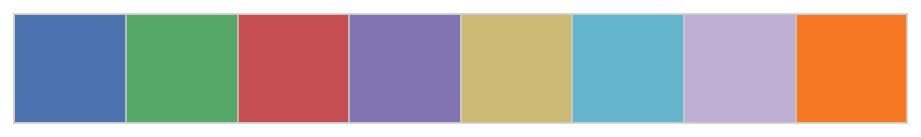

In [3]:
# Settings

# Configuring visualizations
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")
plt.rc('text', usetex=True)

# Set palette
color_list = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9648442906574395, 0.47100346020761247, 0.14197616301422528)]
sns.palplot(color_list)
sns.set_palette(color_list)

# Reloads imported modules
%load_ext autoreload
%autoreload

--- 
# Main code

In [4]:
data_path = "../0_data/"
read_path = "../2_pipeline/1_prepare_data/"
write_path = "../2_pipeline/2_crossholding_analysis/"
fig_path = "../3_results/figures/"
tab_path = "../3_results/data/"
year = 2016

**G:** graph object of networkx. The nodes are the firms and the edges are the capital share of each firm.

In [5]:
# Read Graph Data
year = 2016
G = nx.read_gpickle(read_path + "graph_crossholding_{}.gpickle".format(year))

## Cross-holding matrix

There are $n$ organizations (e.g., countries, banks, or firms) making up a set $N = \{1,…, n\}$.

An firm can hold shares of other firms. For any $i, j ∈ N$ the number $C_{ij} ≥ 0$ is the fraction of organization $j$ owned by organization $i$, where $C_{ii} = 0$ for each $i$. 

The matrix $C$ can be thought of as a network in which there is a directed link from $i$ to $j$ if $i$ owns a positive share of $j$, so that $C_{ij} > 0$.

Paths in this network are called ownership paths. We also sometimes work with a graphical representation of $C$ where directed links point in the opposite direction, the direction in which value (and loss of value) ﬂows. We call the paths in that network cascade paths.

In [6]:
# Creating C matrix
C = nx.adjacency_matrix(G).todense()
C = np.array(C)

# We cannot have total holding companies, so we check if the sum of a column is less than one
sum_shares = sum(C)
pd.Series(sum_shares).describe()

count    1299.000000
mean        0.100860
std         0.268434
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [7]:
# Removing columns that sum less than one
names = np.array(G.nodes)

valid_firms = names[ np.where(sum_shares <= 0.999999)[0] ]
G.remove_nodes_from([n for n in G if n not in valid_firms])

print('Graph information\n', nx.info(G), sep='')

Graph information
Name: Cross-holding Network
Type: DiGraph
Number of nodes: 1267
Number of edges: 540
Average in degree:   0.4262
Average out degree:   0.4262


In [8]:
# Graph Information
print("Remove {} nodes that are isolated \n".format( len( list(nx.isolates(G)) ) ))

G.remove_nodes_from( list(nx.isolates(G)) )

# Largest component
Scc = max(nx.strongly_connected_components(G), key=len)
Wcc = max(nx.weakly_connected_components(G), key=len)

print('Graph information\n', nx.info(G))

Remove 763 nodes that are isolated 

Graph information
 Name: Cross-holding Network
Type: DiGraph
Number of nodes: 504
Number of edges: 540
Average in degree:   1.0714
Average out degree:   1.0714


In [9]:
# Network Characteristics
print("Density: {:.4f}".format(nx.density(G)))
print("Average Clustering: {:.4f}".format(nx.average_clustering(G)))

Density: 0.0021
Average Clustering: 0.0426


In [10]:
# Creating C matrix again
C = nx.adjacency_matrix(G).todense()
C = np.array(C)

n = len( G ) # Number of firms
names = np.array(G.nodes)

np.around(C, decimals=2)

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

After all these cross-holding shares are accounted for, there remains a share $\hat{C}_{ii} := 1 − \sum_{j∈N}C_{ji}$ of organization $i$ not owned by any organization in the system — a share assumed to be positive.

This is the part that is owned by outside shareholders of $i$, external to the system of cross-holdings. The off-diagonal entries of the matrix $\hat{C}$ are defned to be $0$.

The $\hat{C}_{ii}$ residual shares correspond to the control rights of the firm, while the $C_{ij}$’s simply represent obligations to other creditors.

In [11]:
# Creating C_hat matrix
Chat = np.diag(1 - sum(C))
np.around(Chat, decimals=2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.95, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [12]:
# Write Final Cross-holding Graph
nx.write_gpickle(G, write_path + "graph_crossholding_{}.gpickle".format(year))

# Write to GEXF 
# Use 1.2draft so you do not get a deprecated warning in Gephi
nx.write_gexf(G, write_path + "gephi_graph_crossholding_{}.gexf".format(year), 
              version="1.2draft")

## Network Characteristics

We will study integration, diversification and the presence of homophily patterns.

### Diversification

In [16]:
# Descriptive Statistics of Diversification
out_deg = pd.Series(list( dict( G.out_degree(weight=None) ).values() ))

out_deg.describe()

count    504.000000
mean       1.071429
std        1.262259
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       10.000000
dtype: float64

In [17]:
# Percent of nodes with k out-degree
out_deg.value_counts(normalize=True)

1     0.507937
0     0.305556
2     0.107143
3     0.039683
4     0.011905
7     0.007937
5     0.007937
6     0.005952
8     0.003968
10    0.001984
dtype: float64

In [18]:
# Some useful considerations for diversification

print("- Expected degree (diversification): {:.3f}".format(out_deg.mean()) )

print("- When p is very low (well below {:.4f}) most nodes are completely isolated and only a few nodes are linked as pairs.".format(1 / len(G)) )

print("- As p increases (above {:.4f}) some nodes have more than one link and a large component emerges.".format(1 / len(G)) )

print("- As p increases further (beyond {:.4f}) the isolated nodes disappear and network begins to coalesce into a single connected component.".format(np.log( len(G) )) )

- Expected degree (diversification): 1.071
- When p is very low (well below 0.0020) most nodes are completely isolated and only a few nodes are linked as pairs.
- As p increases (above 0.0020) some nodes have more than one link and a large component emerges.
- As p increases further (beyond 6.2226) the isolated nodes disappear and network begins to coalesce into a single connected component.


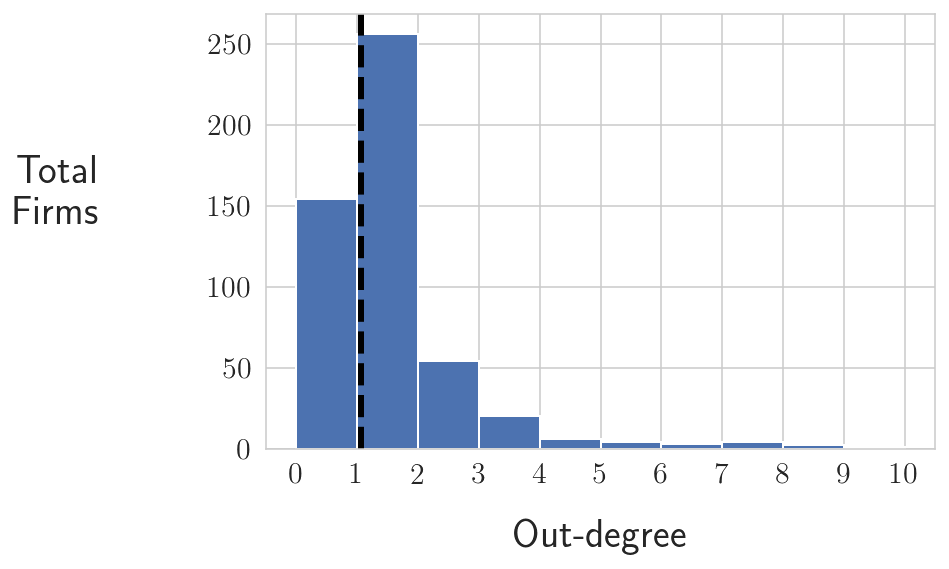

In [19]:
# Histogram of Diversification
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4))
out_deg.plot(kind = "hist", grid="on", label="Out-degree distribution")
plt.axvline(x=out_deg.mean(), color="black", linewidth=3, linestyle="--",
            label='Average out-degree = {:.4f}'.format(out_deg.mean()))
plt.ylabel('Total\nFirms', fontsize=20, rotation=0, labelpad=75)
plt.xlabel('Out-degree', fontsize=20, rotation=0, labelpad=15)
plt.yticks(fontsize=15)
plt.xticks(range(0,11), fontsize=15)
plt.show()

### Integration

In [20]:
# Descriptive Statistics of Integration
sum_shares = C.sum(axis=0) # sum by column
pd.Series(sum_shares).describe()

count    504.000000
mean       0.192745
std        0.328275
min        0.000000
25%        0.000000
50%        0.000033
75%        0.252088
max        0.999999
dtype: float64

In [21]:
# Correlation diversification - integration
corr_diver_integ = out_deg.corr(pd.Series(sum_shares), method='spearman')
print("The correlation between diversification and integration is {:.4f}".format(corr_diver_integ))

The correlation between diversification and integration is -0.5324


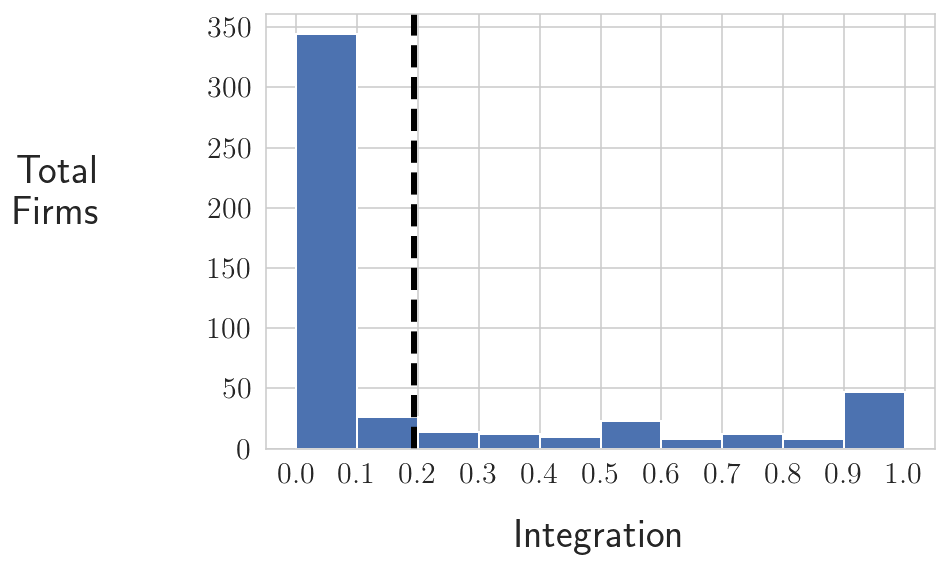

In [22]:
# Histogram of Integration
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4))
pd.Series(sum_shares).plot(kind = "hist", grid="on", label="Integration distribution")
plt.axvline(x=sum_shares.mean(), color="black", linewidth=3, linestyle="--",
            label='Average Integration = {:.4f}'.format(sum_shares.mean()))

plt.ylabel('Total\nFirms', fontsize=20, rotation=0, labelpad=75)
plt.xlabel('Integration', fontsize=20, rotation=0, labelpad=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=15)
plt.show()

### Homophily Patterns

**Assortative Mixing Coefficient**
<br>
<br>
This formula gives $ r = 0 $ when there is no assortative mixing, since $ e_{ij} = a_ib_j $ in that case, and $ r = 1 $ when there is perfect assortative mixing and $ \sum e_{ii} = 1 $. If the network is perfectly disassortative, i.e., every edge connects two vertices of different types, then $ r $ is negative.

In [23]:
# Assortativity Coefficient
r = nx.attribute_assortativity_coefficient(G, attribute="Economic_Sector")
print("Assortativity coefficient of Economic Sectors: {:.4f}".format(r))

Assortativity coefficient of Economic Sectors: 0.1635


We found that $ r = 0.1635 $ for the cross-holding network, implying that this network is moderately assortative by economic sector — firms invest their money in their own economic group a little more often than one would expect on the basis of pure chance.

In [24]:
# Industry matrix
df_crossholding_industry = pd.DataFrame(nx.attribute_mixing_dict(G, "Economic_Sector")).T.fillna(0)
df_crossholding_industry

,General Services,Trade,Real Estate,Financial Activities,Manufacturing,Agriculture,Construction,Transportation
Trade,29.0,34.0,5.0,9.0,16.0,1.0,3.0,10.0
General Services,73.0,17.0,9.0,13.0,15.0,0.0,4.0,2.0
Real Estate,15.0,14.0,6.0,5.0,15.0,1.0,3.0,0.0
Financial Activities,31.0,30.0,6.0,37.0,29.0,3.0,2.0,1.0
Manufacturing,17.0,11.0,1.0,2.0,1.0,3.0,1.0,3.0
Construction,9.0,3.0,2.0,1.0,1.0,0.0,4.0,2.0
Agriculture,1.0,5.0,1.0,3.0,8.0,5.0,2.0,1.0
Transportation,2.0,3.0,0.0,0.0,1.0,0.0,0.0,9.0


Let $e_{ij}$ be the fraction of edges connecting vertices of type $ i $ to vertices of type $ j $ (joint probability).

In [25]:
# Economic Sector Assortativity coefficient (manual calculation)

M = pd.DataFrame(nx.attribute_mixing_matrix(G, "Economic_Sector", normalized=True))
a = M.sum( axis=1 ) # index
b = M.sum( axis=0 ) # column
( np.trace(M) - np.dot(a,b) ) / (1 - np.dot(a,b))

0.16354223205711657

One way to calculate the expected statistical error on the value of $ r $ is to use the jackknife method. Regarding each of the
$ M $ edges in a network as an independent measurement of the contributions to the elements of the matrix $ e $, where $ r_i $ is the value of $ r $ for the network in which the ith edge is removed.

In [26]:
# Standard Deviation Calculation

all_edges = list(G.edges)
r_list = []

for e in all_edges:
    Gcopy = G.copy()
    Gcopy.remove_edge( *e )
    r_i = nx.attribute_assortativity_coefficient(Gcopy, attribute="Economic_Sector")
    dev = (r_i - r) ** 2
    r_list.append(dev)
    
sigma = sum(r_list) ** (1/2)
print( "Sigma: {:.4f}".format(sigma) )
print("Our finding of assortative mixing is strongly statistically significant — a {}σ result".format(int(r / sigma)))

Sigma: 0.0230
Our finding of assortative mixing is strongly statistically significant — a 7σ result


### Industry Statistics

In [27]:
# Construct edge list at industry level

# Define dataframe of nodes and edges
df_nodes = pd.DataFrame.from_dict(G.nodes, orient='index').reset_index()
df_edges = pd.DataFrame.from_dict(G.edges, orient='index').reset_index()

# Merge nodes information to edges (target) dataset
df_edges_industry = pd.merge( df_edges, df_nodes[["index", "Total_Equity", "Economic_Sector"]], how='left', left_on='level_1' , right_on='index').drop("index", axis=1)
df_edges_industry = df_edges_industry.rename(columns={"Economic_Sector": "level_1_sector"})

# Calculate shares in dollars and total links
df_edges_industry["dollar_share"] = df_edges_industry["weight"] * df_edges_industry["Total_Equity"]
df_edges_industry["count_share"] = 1

# Merge nodes information to edges (source) dataset
df_edges_industry = pd.merge( df_edges_industry, df_nodes[["index", "Economic_Sector"]], how='left', left_on='level_0' , right_on='index').drop("index", axis=1)
df_edges_industry = df_edges_industry.rename(columns={"Economic_Sector": "level_0_sector"})

# Select columns and group by industry
df_edges_industry = df_edges_industry[["level_0_sector", "level_1_sector", "count_share", "dollar_share"]]
df_edges_industry = df_edges_industry.groupby(["level_0_sector", "level_1_sector"]).sum().reset_index()

# Add equity of industries
df_equity_industry = df_nodes[["Economic_Sector", "Total_Equity"]].groupby("Economic_Sector").sum().reset_index()
df_edges_industry = pd.merge( df_edges_industry, df_equity_industry, how='left', left_on='level_1_sector' , right_on='Economic_Sector').drop("Economic_Sector", axis=1)

# Calculate % share
df_edges_industry["pct_share"] = df_edges_industry["dollar_share"] / df_edges_industry["Total_Equity"]

df_edges_industry.to_csv(write_path + "edgelist_industry{}.csv".format(year), index=False)

In [28]:
# Graph of industries
Gind = nx.from_pandas_edgelist(df_edges_industry, 
                                "level_0_sector", "level_1_sector", edge_attr=True,  
                                create_using=nx.DiGraph)
print(nx.info(Gind))

Name: 
Type: DiGraph
Number of nodes: 8
Number of edges: 57
Average in degree:   7.1250
Average out degree:   7.1250


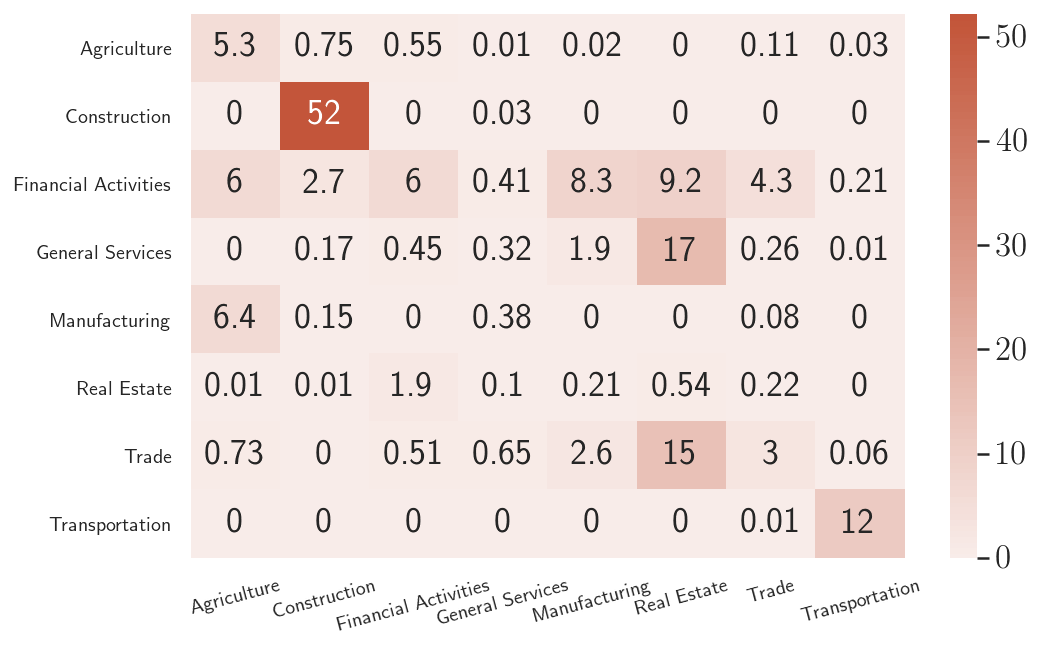

In [29]:
# Heatmap of Cross-holding Industry
df_crossholding_industry = pd.DataFrame(data = nx.adjacency_matrix(Gind, weight="pct_share").toarray(), 
                                index = Gind.nodes, 
                                columns = Gind.nodes) * 100
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(
    ax = ax,
    data = df_crossholding_industry.round(2), 
    vmin = 0, vmax = df_crossholding_industry.max().max(), center = -3,
    cmap = sns.diverging_palette(0, 20, n=200), 
    annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.show()

In [31]:
# Cross-holding shares by Industry level
df = pd.DataFrame(data = nx.adjacency_matrix(Gind, weight="dollar_share").toarray(), 
                  index = Gind.nodes, 
                  columns = Gind.nodes) / 1000
df = df.astype("int")
df_industry_share = pd.DataFrame(index = df.index)
df_industry_share["In"] = np.diag(df)
df_industry_share["Out"] = df.sum(axis=1) - np.diag(df)

# Total Assets by firm
list_assets = list( nx.get_node_attributes(G, "Total_Assets").items() )
df_assets = pd.DataFrame(list_assets, columns=['Ruc', 'Assets'])
df_assets["Assets"] = df_assets["Assets"] / 1000

# Total Cross-holders by firm
list_crossholders = list( dict( G.out_degree(weight=None) ).items() )
df_crossholders = pd.DataFrame(list_crossholders, columns=['Ruc', 'Cross-holders'])

# Economic sector fy firm
list_econ_sector = list( nx.get_node_attributes(G, "Economic_Sector").items() )
df_econ_sector = pd.DataFrame(list_econ_sector, columns=['Ruc', 'Industry'])

# Merge datasets
df_nodes = df_econ_sector.merge(df_assets, 
                                how='outer', on='Ruc').merge(df_crossholders, 
                                                             how='outer', on='Ruc' )

# Calculate statistics
df_industry = df_nodes.groupby("Industry").agg({"Industry": "count",
                                                   "Cross-holders": "sum",
                                                   "Assets": ["mean", "std"]})

df_industry = df_industry.merge(df_industry_share, left_index=True, right_index=True)
df_industry = df_industry.astype("int").style.format("{:,.0f}")
df_industry.index.name = None

# df_industry.to_excel(os.path.join('3_results', , 'data', "industry_stats.xlsx"))
df_industry

,"('Industry', 'count')","('Cross-holders', 'sum')","('Assets', 'mean')","('Assets', 'std')",In,Out
Agriculture,27,26,"8,748","16,992",978,"3,082"
Construction,25,22,"25,482","67,830","76,412",164
Financial Activities,79,139,"8,260","13,952","6,285","133,601"
General Services,132,133,"15,514","83,693","1,409","31,455"
Manufacturing,57,39,"49,424","101,056",1,"3,826"
Real Estate,55,59,"10,584","18,270",330,"6,661"
Trade,100,107,"32,427","147,097","31,236","36,839"
Transportation,29,15,"23,996","97,661","9,351",136


## Financial contagion

We will estimate the ultimate market value lost due to a specific firm's failure.

###  Price of assets

For concreteness, a primitive asset may be thought of as a project that generates a net ﬂow of cash over time. The present value (or market price) of asset $k$ is denoted $p_k$.

In [32]:
# Define DP

p = np.array( list(nx.get_node_attributes(G, "Total_Assets").values()) )

p = p.reshape(len(p),1)

### Dependency matrix

We refer to $A = \hat{C}(I − C)^{−1}$ as the dependency matrix. It is reminiscent of Leontief’s (1951) input-output analysis. Equation $v = A D p$ shows that the value of an organization can be represented as a sum of the values of its ultimate claims
on primitive assets, with organization $i$ owning a share $A_{ij}$ of $j$’s direct holdings of primitive assets. 

This is the portfolio of underlying assets an outside investor would hold to replicate the returns generated by holding organization $i$. To see this, suppose each organization fully owns exactly one proprietary asset, so that $m = n$ and $D = I$. In this case, $A_{ij}$ describes the dependence of i’s value on j’s proprietary asset.

In [33]:
# Define A (dependency matrix)
A = np.dot( Chat, np.linalg.inv( np.eye(n) - C ) )

np.around(A, decimals=2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.95, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [34]:
# Creating Dependency Matrix by Industry Level

Cind = nx.adjacency_matrix(Gind, weight="pct_share").todense()
Cind = np.array(Cind)

Chatind = np.diag(1 - sum(Cind))

Aind = np.dot( Chatind, np.linalg.inv( np.eye(8) - Cind ) )

df_dependency_industry = pd.DataFrame(data = Aind, 
                                index = Gind.nodes, 
                                columns = Gind.nodes) * 100

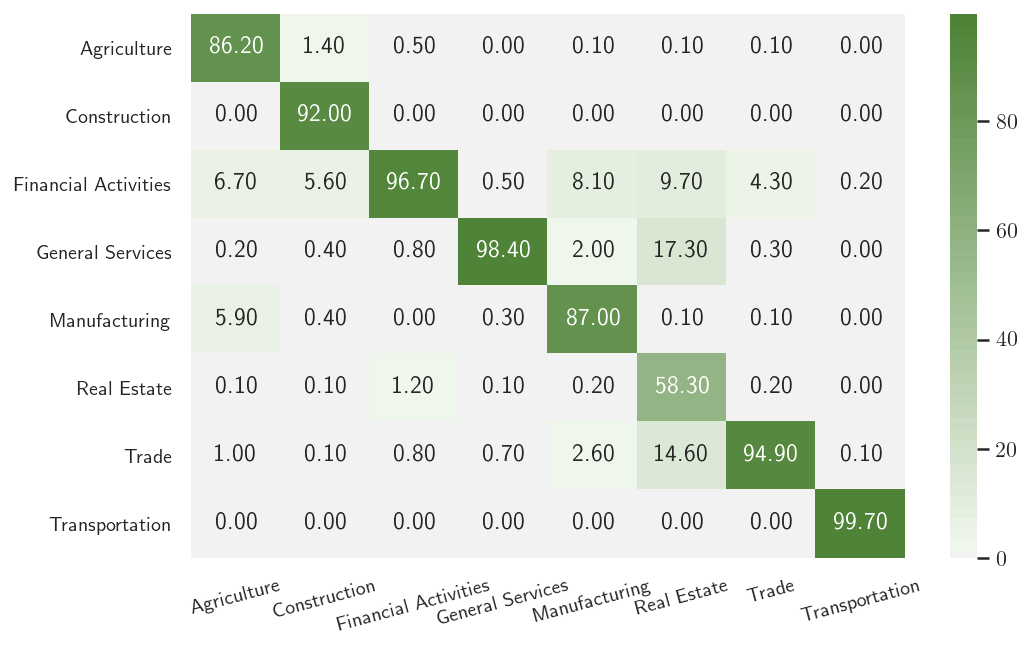

In [35]:
# Heatmap of Dependency Industry
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(
    ax = ax,
    data = df_dependency_industry.round(1), 
    vmin = 0, vmax = df_dependency_industry.max().max(), center = -3,
    cmap = sns.diverging_palette(110, 120, n=100), 
    annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.show()

In [36]:
# Creating Dependency Graph
Gflow = nx.from_numpy_matrix(A, create_using=nx.DiGraph())
dict_temp = {}
for i in range(504):
    dict_temp[i] = names[i]
    
Gflow = nx.relabel_nodes(Gflow, dict_temp)
nx.set_node_attributes(Gflow, nx.get_node_attributes(G, "Economic_Sector"), name="Economic_Sector")

print('Graph information\n', nx.info(Gflow))

Graph information
 Name: 
Type: DiGraph
Number of nodes: 504
Number of edges: 1910
Average in degree:   3.7897
Average out degree:   3.7897


In [37]:
# Homophily in Dependency Network
r = nx.attribute_assortativity_coefficient(Gflow, attribute="Economic_Sector")
print("Assortativity coefficient of Economic Sectors: {:.4f}".format(r))

Assortativity coefficient of Economic Sectors: 0.3066


In [38]:
# Network Characteristics
print("Density: {:.4f}".format( nx.density(Gflow) ))

print("Average Clustering: {:.4f}".format( nx.average_clustering(Gflow) ))

Density: 0.0075
Average Clustering: 0.1500


In [44]:
#  Write to Final Dependency Graph
nx.write_gpickle(Gflow, write_path + "graph_assetflow_{}.gpickle".format(year))


""" Write to GEXF """ 
# Use 1.2draft so you do not get a deprecated warning in Gephi
nx.write_gexf(Gflow, write_path + "gephi_assetflow_{}.gexf".format(year), 
              version="1.2draft")

### Cascades of defaults

We base failure costs on the (market) value of an organization $v_i$. An entry $A_{ij}$ of the dependency matrix describes the proportion of $j$’s failure costs that $i$ bears when $j$ fails as well as $i$’s claims on the primitive assets that $j$ directly holds. If organization $j$ fails, thereby incurring failure costs of $\beta_j$, then $i$’s value will decrease by $A_{ij} \beta_j$.

There is a critical threshold $ \underline{v}_i $ such that if the value available to the owner-operator falls below it, he or she chooses to cease operations and to liquidate the asset. In other words, once $ v_i < \underline{v}_i $ the asset is liquidated.

In [39]:
# Normalize assets

min_value = min(p)
pnorm = p / min_value[0]

In [80]:
from functions import *

In [41]:
econ_sector = nx.get_node_attributes(G, "Economic_Sector")

In [42]:
def result_failures(theta, drop_pct, failcost_pct, group=False):
    """
    Return a dataframe with firm(s) that received the shock, and the total firms affected
    """
    firms_failed_list = []
    costs_failed_list = []
    single_firm_list = []
    other_firm_list = []

    if group:
        for name_group in set(econ_sector.values()):
            index_group = firms_econ_sector(econ_sector, G, name_group)

            result_firms, result_costs, idx_failed_firms = cascade_failures(A, theta, pnorm, index_group, drop_pct, failcost_pct)
            firms_failed_list.append( result_firms )
            costs_failed_list.append( result_costs )
            single_firm_list.append( name_group )
            other_firm_list.append([names[fidx] for fidx in idx_failed_firms])
        
    else:
        for f in np.arange(n):
            result_firms, result_costs, idx_failed_firms = cascade_failures(A, theta, pnorm, [f], drop_pct, failcost_pct)
            firms_failed_list.append( result_firms )
            costs_failed_list.append( result_costs )
            single_firm_list.append( names[f] )
#             other_firm_list += [names[ff] for ff in fff]
            other_firm_list.append([names[fidx] for fidx in idx_failed_firms])
        
    df_single_firm = pd.DataFrame([single_firm_list, firms_failed_list, costs_failed_list, other_firm_list]).T
    df_single_firm.columns = ["Firms", "Total_Affected", "Total_Costs", "List_Firms_Affected"]
    df = df_single_firm.sort_values("Total_Affected", ascending=False).reset_index(drop=True)
    
    return df

### Firms' Defaults

In [43]:
# Calculating default of each firm with th=0.95 drop=100, cost=30
df = result_failures(0.95, 0, 0.30, group=False)
df["List_Firms_Affected"] = df["List_Firms_Affected"].apply(lambda x: x[1:-1])
df["Industry"] = df["Firms"].map(econ_sector)
df[:3]

,Firms,Total_Affected,Total_Costs,List_Firms_Affected,Industry
0,1790008967001,19,1333.27,"[[1790607127001, 1791123298001, 1791267990001,...",Financial Activities
1,1790016919001,19,6799.98,"[[1790013324001, 1790384128001, 1790457044001,...",Trade
2,1790370690001,8,21236.6,"[[1390000991001, 1790340465001], [179126251400...",Agriculture


In [48]:
# Tables of FIRMS contagion results aggregated at each industry
theta = [0.95, 0.90, 0.85]
drop = [0, 0.5]
fail_cost = [0.30, 0.20]
industry_list = list( df["Industry"].unique() )

aggregated_results = pd.DataFrame()

for d in range( len(drop) ):
    for c in range( len(fail_cost) ):
        for t in range( len(theta) ):
            param = "drop{:.0f}_th{:.0f}_cost{:.0f}".format( (1-drop[d])*100, theta[t]*100, fail_cost[c]*100 )

            # Calculate results of failure
            df = result_failures(theta[t], drop[d], fail_cost[c], group=False)
            df["List_Firms_Affected"] = df["List_Firms_Affected"].apply(lambda x: x[1:-1])
            df["Industry"] = df["Firms"].map(econ_sector)
            
            # Construct matrix of waves
            wave_list = ["wave1", "wave2"]
            index = [["wave1"] * 8 + ["wave2"] * 8, industry_list * 2]
            df_wave = pd.DataFrame(index = index, columns = industry_list)

            for ind in industry_list:
                results_temp = pd.DataFrame()
                for w in range( len(wave_list) ):
                    # Select one industry
                    df_ind = df[df["Industry"] == ind]
                    affected_series = df_ind["List_Firms_Affected"].apply(lambda x: x[w] if len(x) > w else [])
                    # First concatenate
                    affected_list = np.concatenate(list(affected_series), axis=None)
                    # Second concatenate
                    if len(affected_list) > 0:
                        affected_list = np.concatenate(affected_list, axis=None)
                    # Get results and order them
                    results_wave = pd.DataFrame(pd.DataFrame(affected_list)[0].map(econ_sector).value_counts())
                    results_wave.columns = [ind]
                    # Create multi-index with each wave
                    results_wave = pd.concat([results_wave], keys=[wave_list[w]])
                    # Concatenate results_temp
                    results_temp = pd.concat([results_temp, results_wave])
                df_wave[ind] = results_temp

            # Sum the failures of each simulation (by industry)
            df_wave = df_wave.groupby(level=[0]).sum()
            # Create multi-index with each parameter
            df_wave = pd.concat( [df_wave], keys=[param])
            aggregated_results = pd.concat([aggregated_results, df_wave])

In [78]:
# Dictionary of colors for each economics sector
color_sector = {'Trade': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), 
                'General Services': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), 
                'Real Estate': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), 
                'Financial Activities': (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
                'Manufacturing': (0.8, 0.7254901960784313, 0.4549019607843137), 
                'Construction': (0.39215686274509803, 0.7098039215686275, 0.803921568627451), 
                'Agriculture': (0.7450980392156863, 0.6823529411764706, 0.8313725490196079), 
                'Transportation': (0.9648442906574395, 0.47100346020761247, 0.14197616301422528)}

# Dictionary of initials for each economics sector
initial_sector = {'Trade': "T", 
                'General Services': "S", 
                'Real Estate': "E", 
                'Financial Activities': "F",
                'Manufacturing': "M", 
                'Construction': "C", 
                'Agriculture': "A", 
                'Transportation': "B"}

In [77]:
# Add ID to nodes dataframe
df_nodes["ID"] = df_nodes.groupby(['Ruc']).ngroup() + 1
ruc_id = dict( zip(df_nodes.Ruc, df_nodes.ID) )
final_list_firms = set()

In [91]:
df_nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ruc            504 non-null    object 
 1   Industry       504 non-null    object 
 2   Assets         504 non-null    float64
 3   Cross-holders  504 non-null    int64  
 4   ID             504 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 43.6+ KB


In [49]:
# Write integration and diversification of all firms
df_integration = pd.concat([pd.Series(G.nodes), pd.Series(C.sum(axis=0))], axis=1, keys=["Ruc", "Integration"])
df_nodes_contagious = pd.merge(df_nodes, df_integration, how="left", on="Ruc")
df_nodes_contagious = df_nodes_contagious.rename({"Cross-holders": "Diversification"}, axis=1)
df_nodes_contagious = df_nodes_contagious[["ID", "Industry", "Assets", "Integration", "Diversification"]]

In [65]:
df_threshold = pd.DataFrame([]) 
for t in np.arange(0, 1, 0.01):
    t = round(t, 2)    # round the threshold
    df = result_failures(t, 0, 0.30, group=False)
    df["Threshold"] = t
    df_threshold = df_threshold.append(df, ignore_index=True)

df = df_threshold[["Total_Affected", "Threshold"]].groupby("Threshold").sum()
df.columns = ["Total Affected"]
val = df[df["Total Affected"] > 0].index[0]

df.to_csv(write_path + "threshold_change{}.csv".format(year))

### Industry Defaults

In [71]:
# Calculating default of each INDUSTRY with th=0.95 drop=100, cost=20
df = result_failures(0.95, 0, 0.20, group=True)
df["List_Firms_Affected"] = df["List_Firms_Affected"].apply(lambda x: x[1:-1])
df

,Firms,Total_Affected,Total_Costs,List_Firms_Affected
0,Manufacturing,42,53161.7,"[[1191757544001, 1790607127001, 1791262514001,..."
1,Trade,40,24222.7,"[[1790044297001, 1790371107001, 1190000709001,..."
2,General Services,27,14176,"[[1790371107001, 1790015718001, 1790015726001,..."
3,Financial Activities,18,8697.85,"[[1790428400001, 1790360741001, 1790388948001,..."
4,Real Estate,16,21461.9,"[[1790044297001, 1792504538001, 1790453146001,..."
5,Agriculture,10,16636.3,"[[1390000991001, 1790340465001, 1790983447001,..."
6,Transportation,6,609.221,"[[1891724094001, 1290046374001, 1791240537001,..."
7,Construction,6,7875.33,"[[1790424472001, 1790366022001, 1190049406001,..."


In [122]:
# Table of industry contagion
theta = [0.95, 0.90, 0.85]
drop = [0, 0.5]
fail_cost = [0.30, 0.20]

aggregated_results = pd.DataFrame()

for d in range( len(drop) ):
    for c in range( len(fail_cost) ):
        for t in range( len(theta) ):
            param = "drop{:.0f}_th{:.0f}_cost{:.0f}".format( (1-drop[d])*100, theta[t]*100, fail_cost[c]*100)

            # Calculate results of failure
            df = result_failures(theta[t], drop[d], fail_cost[c], group=True)
            df["List_Firms_Affected"] = df["List_Firms_Affected"].apply(lambda x: x[1:-1])
            # Construct matrix of waves
            wave_list = ["wave1", "wave2"]
            index = [["wave1"] * 8 + ["wave2"] * 8, industry_list * 2]
            df_wave = pd.DataFrame(index = index, columns = industry_list)

            for ind in industry_list:
                results_temp = pd.DataFrame()
                for w in range( len(wave_list) ):
                    # Select one industry
                    df_ind = df[df["Firms"] == ind]
                    affected_series = df_ind["List_Firms_Affected"].apply(lambda x: x[w] if len(x) > w else [])
                    # First concatenate
                    affected_list = np.concatenate(list(affected_series), axis=None)
                    # Second concatenate
                    if len(affected_list) > 0:
                        affected_list = np.concatenate(affected_list, axis=None)
                    # Get results and order them
                    results_wave = pd.DataFrame(pd.DataFrame(affected_list)[0].map(econ_sector).value_counts())
                    results_wave.columns = [ind]
                    # Create multi-index with each wave
                    results_wave = pd.concat([results_wave], keys=[wave_list[w]])
                    # Concatenate results_temp
                    results_temp = pd.concat([results_temp, results_wave])
                df_wave[ind] = results_temp

            # Sum the failures of each simulation (by industry)
            df_wave = df_wave.groupby(level=[0]).sum()
            # Create multi-index with each parameter
            df_wave = pd.concat( [df_wave], keys=[param])
            aggregated_results = pd.concat([aggregated_results, df_wave])

In [118]:
df_final = pd.DataFrame([]) 
for t in [0.95, 0.9, 0.8, 0.7]:
    for d in np.arange(0, 1.1, 0.1):
        d = round(d, 2) # Round the threshold, I do not why it gives me errors
        df = result_failures(t, d, 0.2, group=True)
        df["Drop_Value"] = 1 - d
        df["Threshold"] = t
        df_final = df_final.append(df, ignore_index=True)

df = df_final[df_final["Threshold"] == 0.95]
df = df[["Firms", "Total_Affected", "Drop_Value"]]
df.to_csv(write_path + "industry_shocks{}.csv".format(year), index=False)

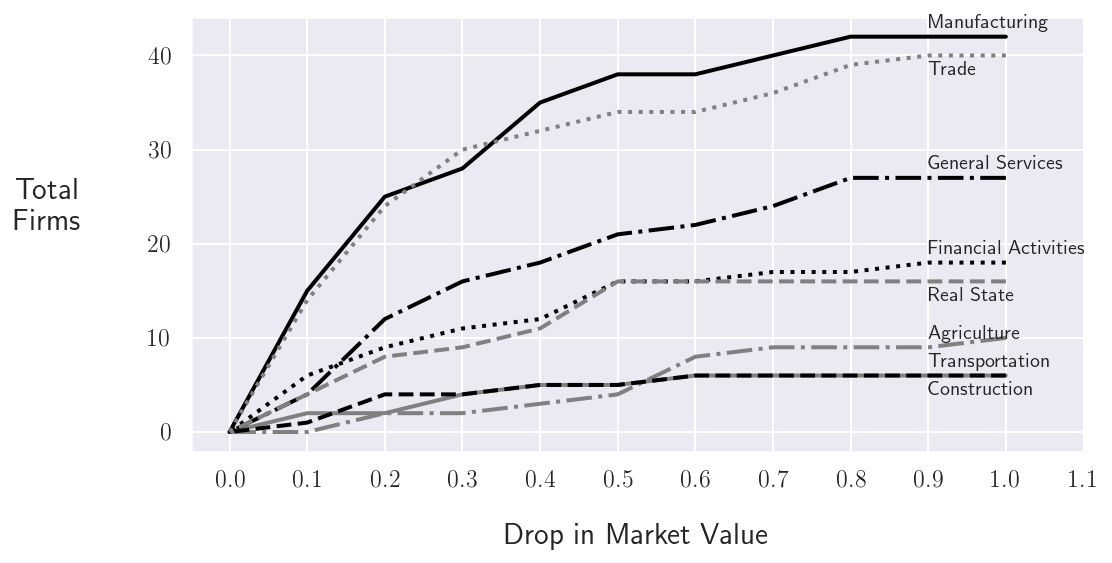

In [126]:
# Plot of simulations by industry
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))

for key, group in df.groupby(["Firms"]):
    ax = group.plot(ax=ax, kind='line', 
                    x="Drop_Value", y="Total_Affected", 
                    style=style_sector[key], label=key, linewidth=2, 
                    color=color_sector[key], legend=None)
    
plt.text(0.9, 43, "Manufacturing", fontsize=10)
plt.text(0.9, 38, "Trade", fontsize=10)
plt.text(0.9, 28, "General Services", fontsize=10)
plt.text(0.9, 19, "Financial Activities", fontsize=10)
plt.text(0.9, 14, "Real State", fontsize=10)
plt.text(0.9, 10, "Agriculture", fontsize=10)
plt.text(0.9, 7, "Transportation", fontsize=10)
plt.text(0.9, 4, "Construction", fontsize=10)

plt.ylabel('Total\nFirms', fontsize=15, rotation=0, labelpad=50)
plt.xlabel('Drop in Market Value', fontsize=15, rotation=0, labelpad=15)
plt.yticks(np.arange(0, 50, 10), fontsize=12)
plt.xticks(np.arange(0, 1.2, 0.1), fontsize=12)          
plt.show()

## Graph

In [92]:
pos = nx.spring_layout(G)

In [93]:
cat_colors = pd.Categorical(pd.Series(list(econ_sector.values()))).codes

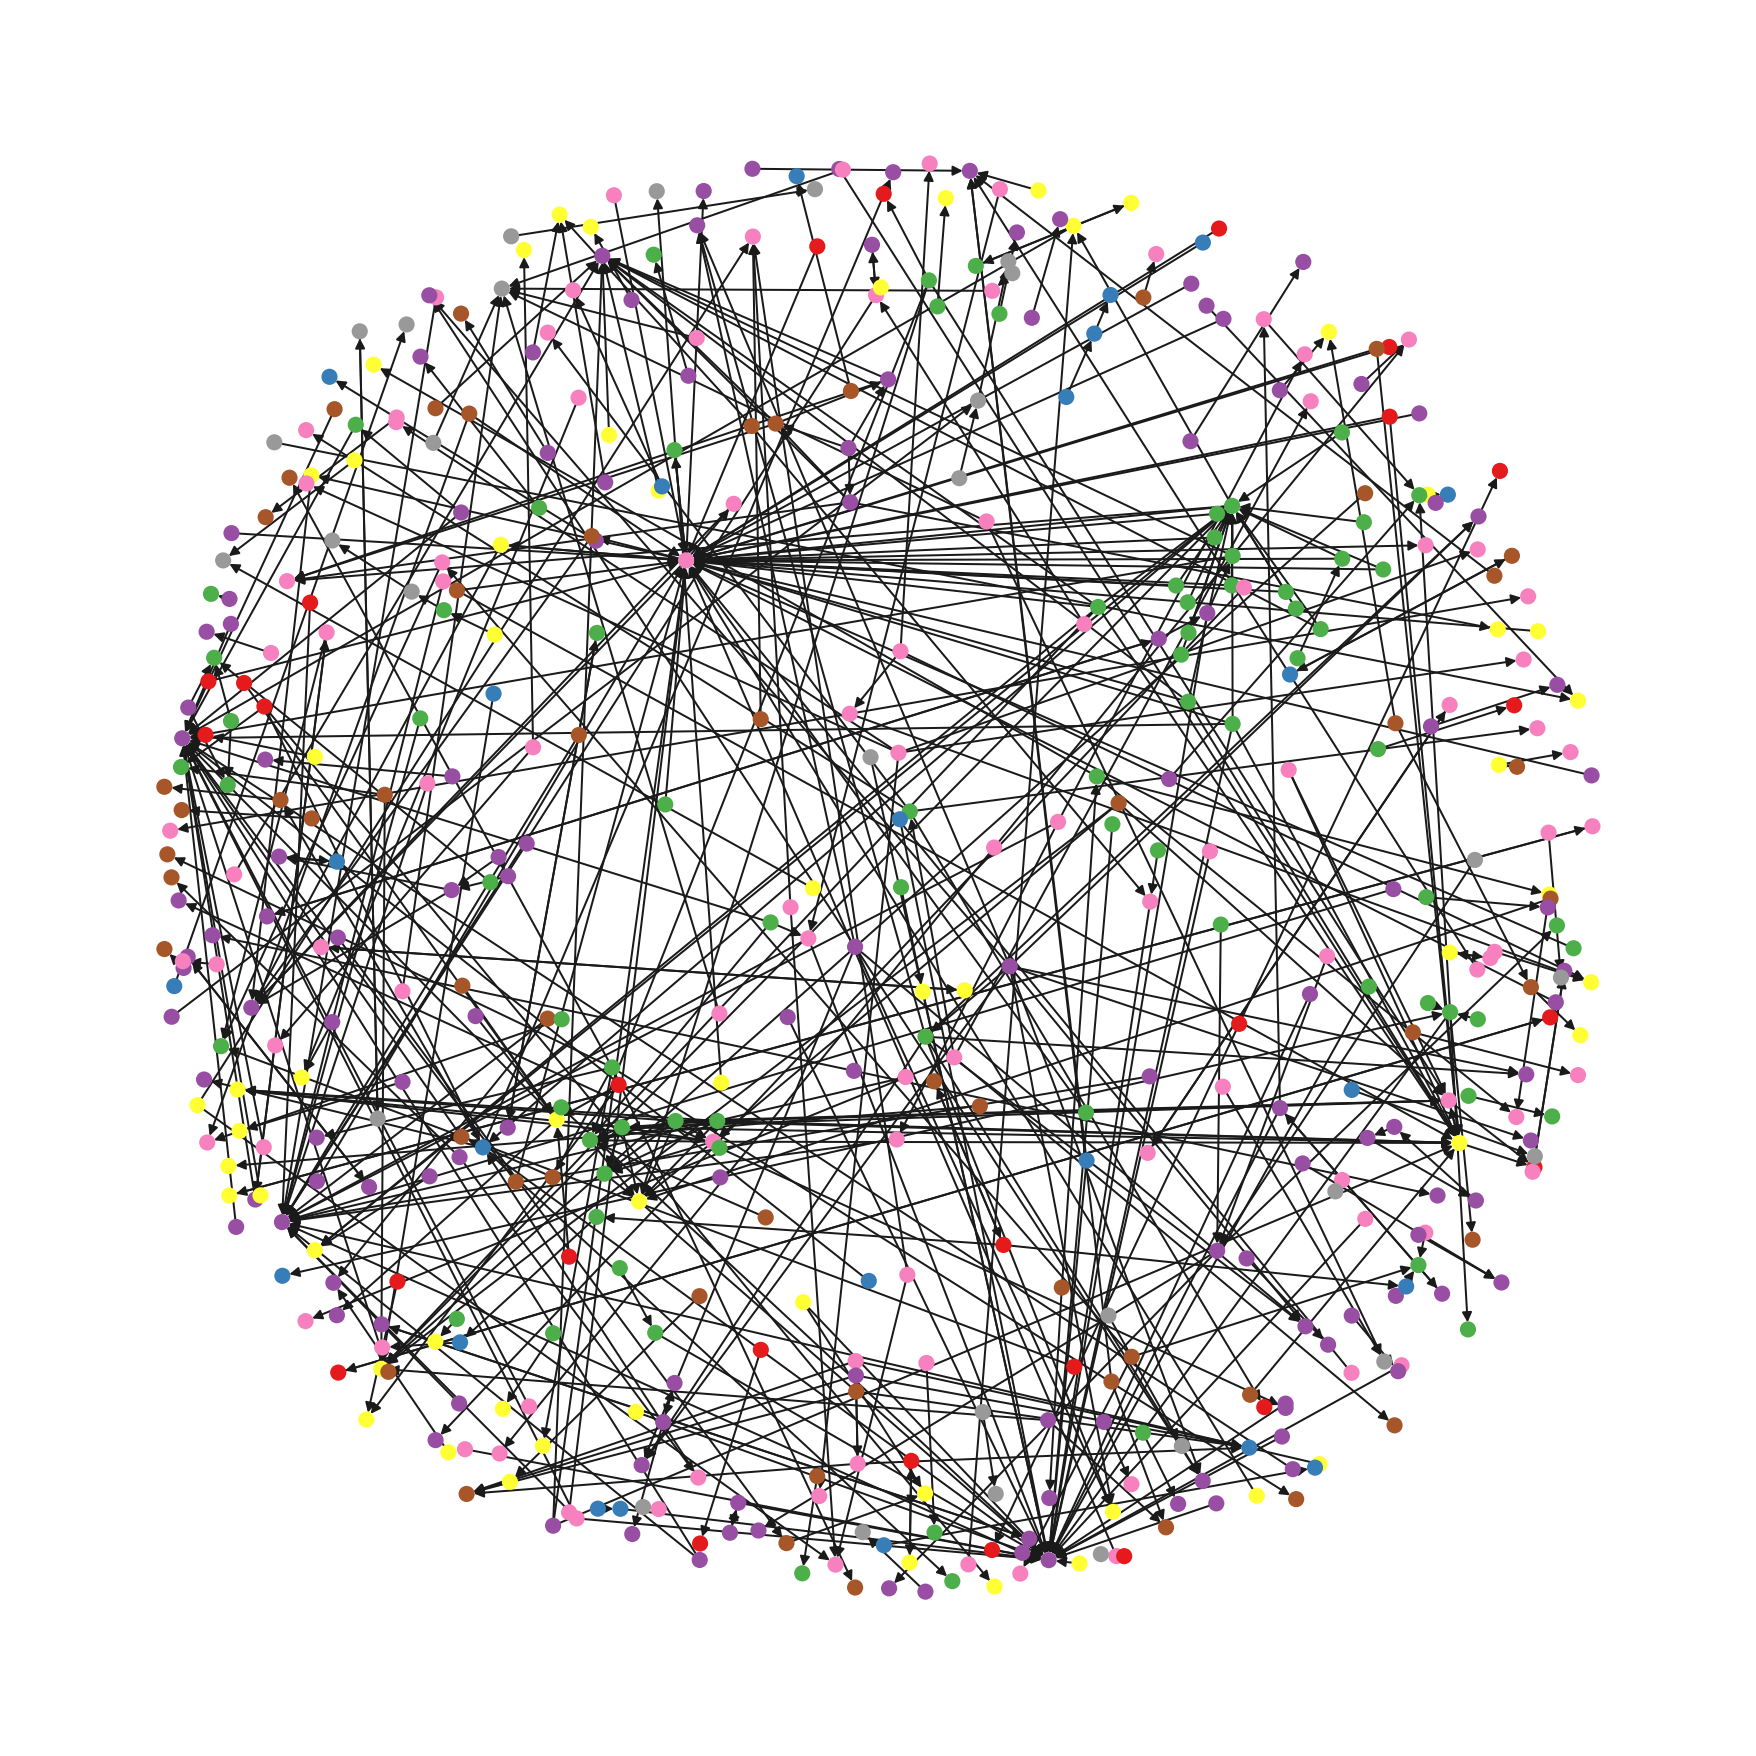

In [94]:
plt.figure(figsize=(12,12)) 
# nx.draw(G, pos, node_color="steelblue", node_size=revenue_values, cmap=plt.cm.Blues)
nx.draw(G, pos, node_color=cat_colors, node_size=50, cmap=plt.cm.Set1)
plt.show()